In [1]:
import galsim
import numpy as np
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.animation as anim
from astropy.utils.console import ProgressBar
import warnings
import matplotlib.pyplot as plt

seed = 1
argr0_500 = 0.2 #fried parameter at 500nm 
nlayers = 6 #num atmospheric layer
time_step = 0.03 #increment time steps for advancing phase screens
exptime = 3 # total time to integrate
screen_size = 102.4 #size of atmospheric screen
screen_scale = 0.1 #reso of atmospheric screen
max_speed = 20 #max wind speed
x = 0 #x coor of psf
y = 0 #y coor of psf
lam = 700 #wavelen
diam =4.0 #size of telescope pupil
obscuration = 0 #linear fractional obscration of the pupil
nstruts = 0 #num strurts supporting secondary obscruration
strut_thick = 0.05 #thickness of struts as fraction of aperture diam
strut_angle = 0 #starting angle of 1st strut
psf_nx = 512 #output psf image dimension
psf_scale = 0.005 # scale of psf output in ''
accumulate = False
pad_factor = 1 #factor to pad psf interpolating image to avoid aliasing
oversampling = 1 #factor to oversample psf interpolated image
psf_vmax = 0.0003 #vmax kwarg for psf image
wf_vmax = 50 #vmax kwarg for wavefront image
outfile = "test1.mp4"
accumulateint = True


def change_r0(r0=argr0_500, nlayers=nlayers, max_speed=max_speed, lam=lam ):
    #initiate random num
    rng = galsim.BaseDeviate(seed)
    u = galsim.UniformDeviate(rng)

    Ellerbroek_alts = [0.0, 2.58, 5.16, 7.73, 12.89, 15.46]  # km
    Ellerbroek_weights = [0.652, 0.172, 0.055, 0.025, 0.074, 0.022]
    #create table of alt-weights
    Ellerbroek_interp = galsim.LookupTable(Ellerbroek_alts, Ellerbroek_weights,interpolant='linear')
    #create altitude with chosen num of layers
    alts = np.max(Ellerbroek_alts)*np.arange(nlayers)/(nlayers-1)
    #find corresponding weights from table
    weights = Ellerbroek_interp(alts)  # interpolate the weights
    weights /= sum(weights)  # and renormalize

    spd = []  # Wind speed in m/s
    dirn = [] # Wind direction in radians
    r0_500 = [] # Fried parameter in m at a wavelength of 500 nm
    for i in range(nlayers):
        spd.append(u()*max_speed) 
        dirn.append(u()*360*galsim.degrees) 
        r0_500.append(r0*weights[i]**(-3./5))
        """print("Adding layer at altitude {:5.2f} km with velocity ({:5.2f}, {:5.2f}) m/s, "
              "and r0_500 {:5.3f} m."
              .format(alts[i], spd[i]*dirn[i].cos(), spd[i]*dirn[i].sin(), r0_500[i]))"""
    atm = galsim.Atmosphere(r0_500=r0_500, speed=spd, direction=dirn, altitude=alts, rng=rng,
                                screen_size=screen_size, screen_scale=screen_scale)
    #store image
    psf_img_sum = galsim.ImageD(psf_nx, psf_nx, scale=psf_scale)
    psfint_img_sum = galsim.ImageD(psf_nx, psf_nx, scale=psf_scale)
    #field angle at which to compute psf
    theta = (x*galsim.arcmin, y*galsim.arcmin)
    #aperture of pupil
    aper = galsim.Aperture(diam=diam, lam=lam, obscuration=obscuration,
                               nstruts=nstruts, strut_thick=strut_thick,
                               strut_angle=strut_angle*galsim.degrees,
                               screen_list=atm, pad_factor=pad_factor,
                               oversampling=oversampling)
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    metadata = dict(title='Wavefront Movie', artist='Matplotlib')
    writer = anim.FFMpegWriter(fps=15, bitrate=5000, metadata=metadata)
    fig, (psf1,wf_ax,psf2) = plt.subplots(nrows=1,ncols=3, figsize=(15, 4.5))
    FigureCanvasAgg(fig)

    # Axis for the first PSF
    fig.set_facecolor("k")
    psf1.set_xlabel("Arcsec")
    psf1.set_ylabel("Arcsec")
    psf1_im = psf1.imshow(np.ones((128, 128), dtype=np.float64), animated=True,
                   vmin=0.0, vmax=psf_vmax, cmap='hot',
                   extent=np.r_[-1, 1, -1, 1]*0.5*psf_nx*psf_scale)
    psf1.set_title("Instantaneous PSF")

    # Axis for the 2nd PSF
    psf2.set_xlabel("Arcsec")
    psf2.set_ylabel("Arcsec")
    psf2_im = psf2.imshow(np.ones((128, 128), dtype=np.float64), animated=True,
                   vmin=0.0, vmax=psf_vmax, cmap='hot',
                   extent=np.r_[-1, 1, -1, 1]*0.5*psf_nx*psf_scale)
    psf2.set_title("PSF integrated over time")

    # Axis for the wavefront image on the right.
    wf_ax.set_xlabel("Meters")
    wf_ax.set_ylabel("Meters")
    wf_im = wf_ax.imshow(np.ones((128, 128), dtype=np.float64), animated=True,
                         vmin=-wf_vmax, vmax=wf_vmax, cmap='YlGnBu',
                         extent=np.r_[-1, 1, -1, 1]*0.5*aper.pupil_plane_size)

    divider = make_axes_locatable(wf_ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(wf_im, cax=cax, orientation='vertical')


    # Overlay an alpha-mask on the wavefront image showing which parts are actually illuminated.
    ilum = np.ma.masked_greater(aper.illuminated, 0.5)
    wf_ax.imshow(ilum, alpha=0.4, extent=np.r_[-1, 1, -1, 1]*0.5*aper.pupil_plane_size)

    # Color items white to show up on black background
    for ax in [psf1, wf_ax, psf2]:
        for _, spine in ax.spines.items():
            spine.set_color('w')
        ax.title.set_color('w')
        ax.xaxis.label.set_color('w')
        ax.yaxis.label.set_color('w')
        ax.tick_params(axis='both', colors='w')


    etext = psf1.text(0.05, 0.92, '', transform=psf1.transAxes)
    etext.set_color('w')

    nstep = int(exptime / time_step)
    t0 = 0.0


    for i in range(nstep):
        wf = atm.wavefront(aper.u, aper.v, t0, theta=theta) * 2*np.pi/lam  # radians
        psf = atm.makePSF(lam=lam, theta=theta, aper=aper,
                          t0=t0, exptime=time_step)
        psf_img0 = psf.drawImage(nx=psf_nx, ny=psf_nx, scale=psf_scale)
        if accumulate:
            psf_img_sum += psf_img0
            psf_img = psf_img_sum/(i+1)
        else:
            psf_img = psf_img0


        # Calculate simple estimate of size and ellipticity
        e = galsim.utilities.unweighted_shape(psf_img)

        # Update t0 for the next movie frame.
        t0 += time_step

        # Matplotlib code updating plot elements
        wf_im.set_array(wf)
        wf_ax.set_title("Wavefront Image. t={:5.2f} s".format(i*time_step))
        psf1_im.set_array(psf_img.array)
        etext.set_text("$e_1$={:6.3f}, $e_2$={:6.3f}, $r^2$={:6.3f}".format(
                e['e1'], e['e2'], e['rsqr']*psf_scale**2))

        #THIRD FRAME
        psfint = atm.makePSF(lam=lam, theta=theta, aper=aper,
                          t0=t0, exptime=time_step)
        psfint_img0 = psfint.drawImage(nx=psf_nx, ny=psf_nx, scale=psf_scale)
        if accumulateint:
            psfint_img_sum += psfint_img0
            psfint_img = psfint_img_sum/(i+1)
        else:
            psfint_img = psfint_img0
        psf2_im.set_array(psfint_img.array)
    plt.show(fig)


# 1. change fried parameter 

## r0 = 0.1

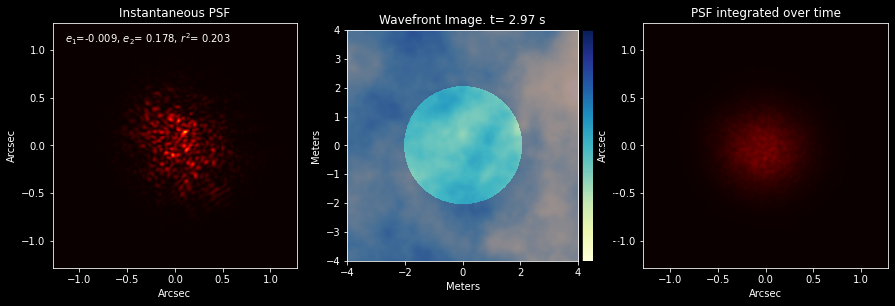

In [61]:
change_r0(0.1)

## r0 = 0.2

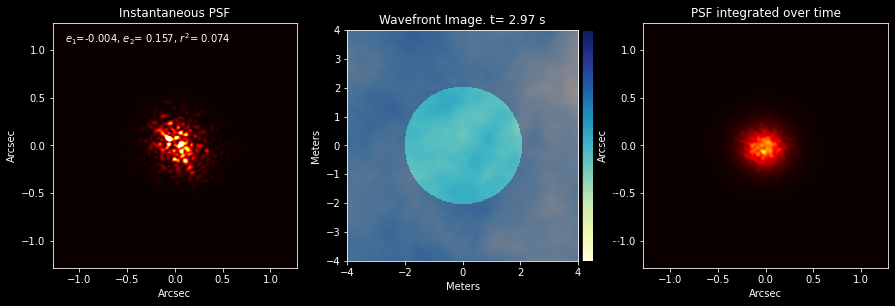

In [59]:
change_r0(0.2)

## r0 = 0.35

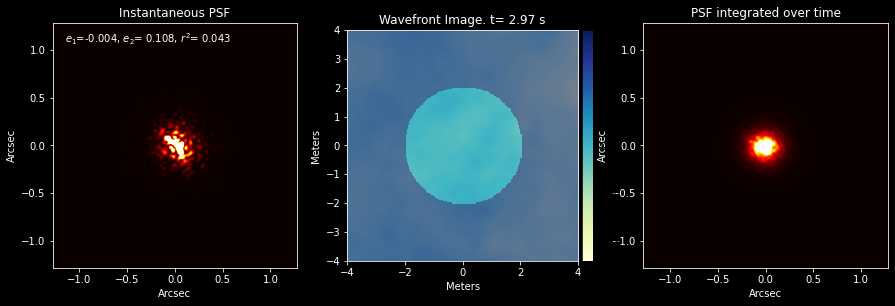

In [60]:
change_r0(0.35)

## we see that small r0 values correspond to bigger PSF, similar to smaller aperture correpsonds to more diffraction

# 2. change number of layers

## 2 layers

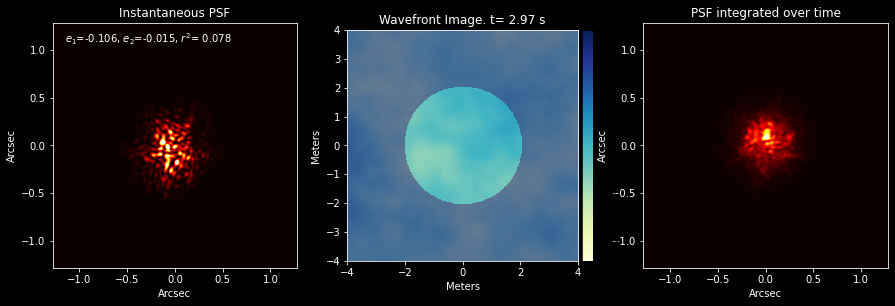

In [66]:
change_r0(nlayers=2)

# 6 layers

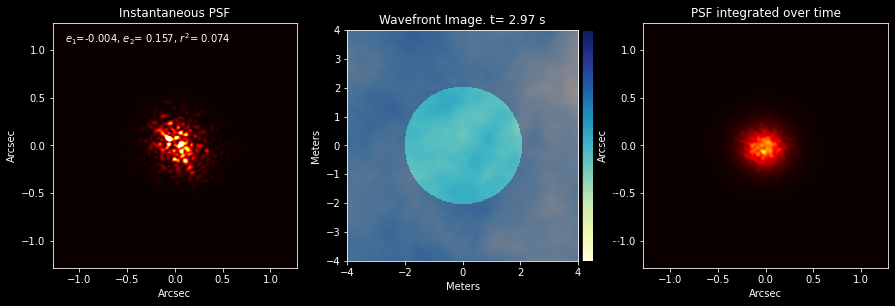

In [64]:
change_r0(nlayers=6)

## 10 layers

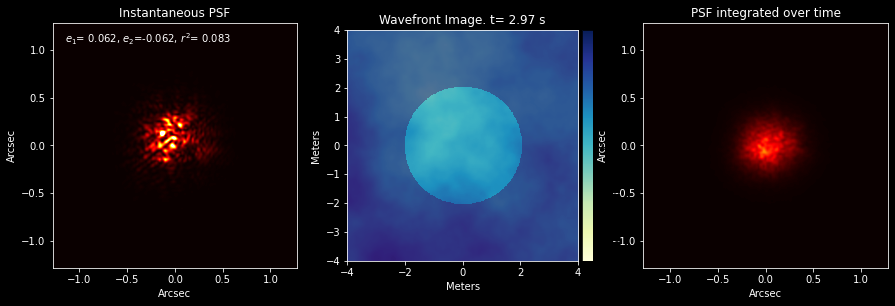

In [65]:
change_r0(nlayers=10)

## more atmosphere smooths out the psf, because each layer adds another phase to the wavefront

# 3. change wind

## wind speed = 3m/s

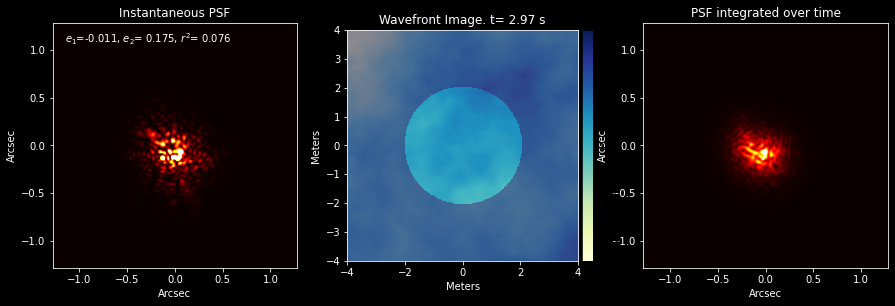

In [70]:
change_r0(max_speed=3)

## wind speed = 20 m/s

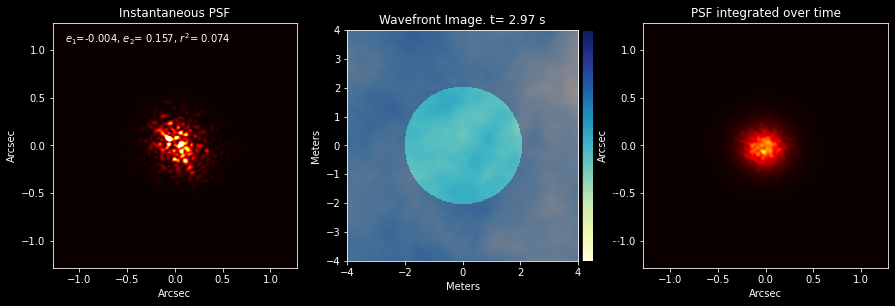

In [68]:
change_r0(max_speed=20)

## wind speed = 40m/s

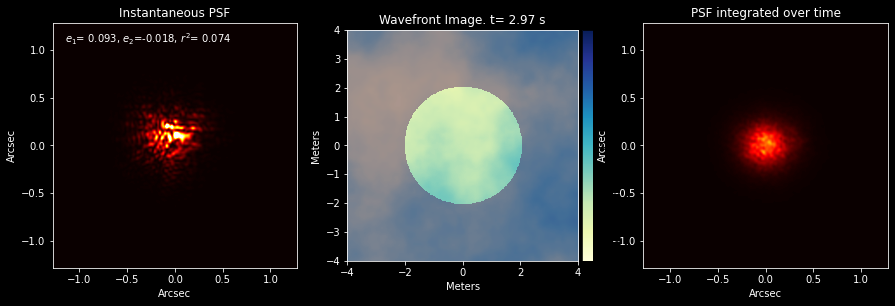

In [69]:
change_r0(max_speed=40)

## stronger wind affects the psf more, which makes sense because layers moving increase the turbulence, which blurs the psf more

# 4. change wavelength of light

## wavelength 500nm, blue light

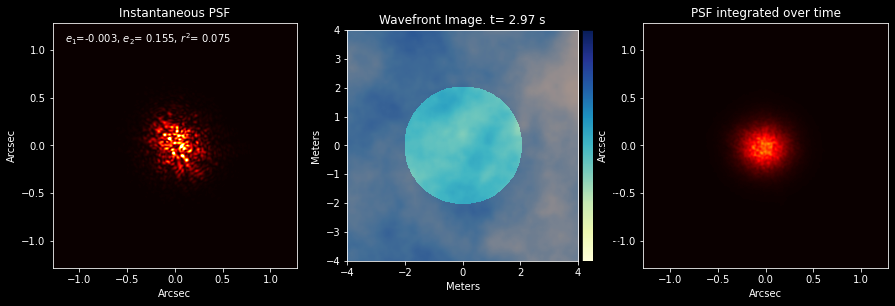

In [71]:
change_r0(lam = 500)

## wavelength 600nm, yellow light

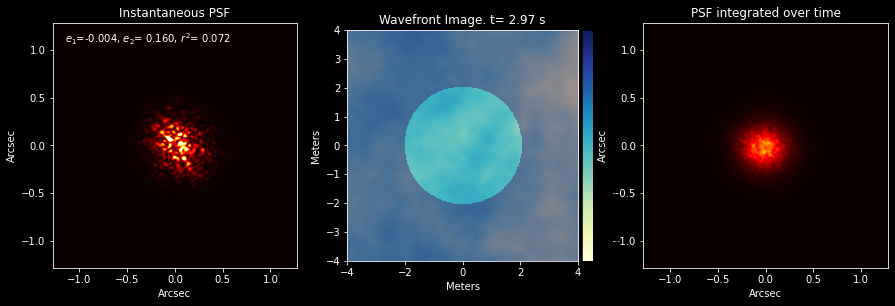

In [73]:
change_r0(lam = 600)

## wavelength 700nm, red light

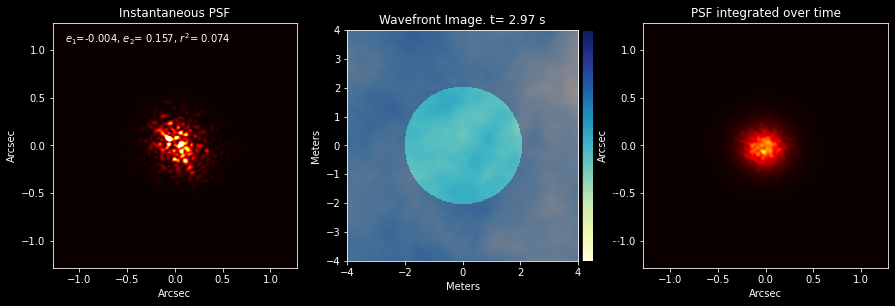

In [72]:
change_r0(lam = 700)

## blue light is more affected by atmospheric psf. is this an observation of the chromatic effect?